<a href="https://colab.research.google.com/github/Python-Neiva/transfer-learning/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 1. Importing Libraries

In [ ]:
pip install keras-tuner --upgrade

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperParameters
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, AUC

# 2. Loading and Preprocessing the CIFAR-10 Dataset



*   Load the CIFAR-10 dataset
*   Add normalization to scale pixel values to the range [0, 1].



In [ ]:
# Load the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


In [ ]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# 3. Visualizing the Data

## 3.1 Visualizing Sample Images

In [ ]:
def visualize_samples(images, labels):
    plt.figure(figsize=(6, 4))
    sns.set(style="whitegrid")  # Apply Seaborn style

    for i in range(12):
        plt.subplot(4, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i][0]], fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

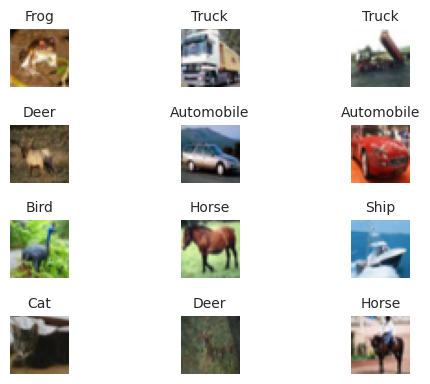

In [ ]:
visualize_samples(train_images, train_labels)

## 3.2 Visualizing Class Distribution

In [ ]:
# Extract the class labels from the training data
train_class_labels = [label[0] for label in train_labels]


### Create a DataFrame for visualization
- Step 1: Create a DataFrame from your class labels.
- Step 2: Map each class label to its corresponding class name using a dictionary or list.


In [ ]:
df_train_labels = pd.DataFrame(train_class_labels, columns=['Class'])
df_train_labels['Class'] = df_train_labels['Class'].apply(lambda x: class_names[x])





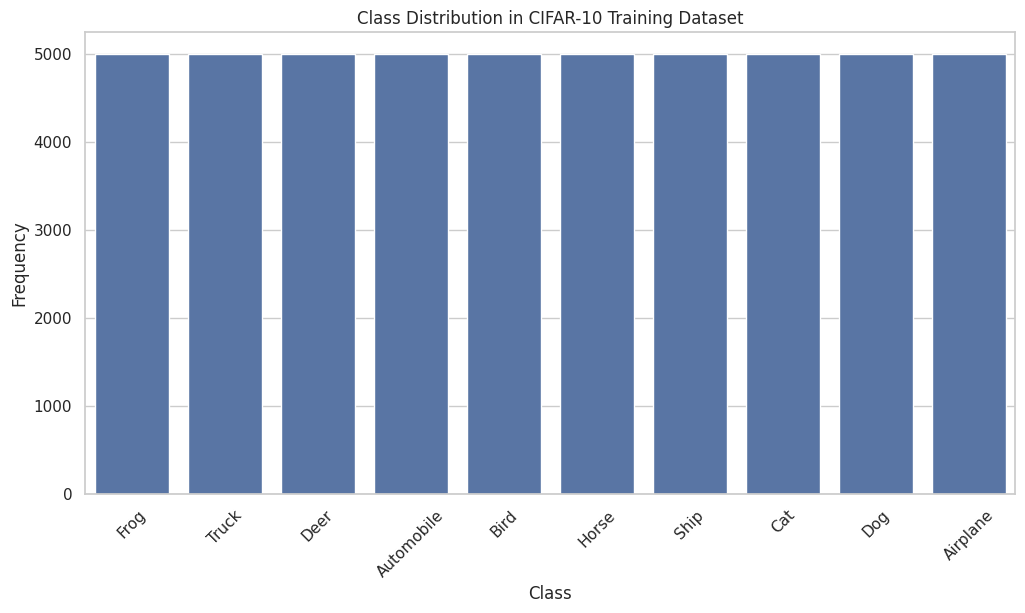

In [ ]:
# Plot the class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train_labels, x='Class')
plt.title('Class Distribution in CIFAR-10 Training Dataset')
plt.xticks(rotation=45)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

## 3.3 Visualizing Image Mean and Standard Deviation Across Channels

In [ ]:
mean_r = np.mean(train_images[:, :, :, 0])
mean_g = np.mean(train_images[:, :, :, 1])
mean_b = np.mean(train_images[:, :, :, 2])

In [ ]:
std_r = np.std(train_images[:, :, :, 0])
std_g = np.std(train_images[:, :, :, 1])
std_b = np.std(train_images[:, :, :, 2])

In [ ]:
print(f"Mean of R channel: {mean_r:.4f}, G channel: {mean_g:.4f}, B channel: {mean_b:.4f}")
print(f"Standard Deviation of R channel: {std_r:.4f}, G channel: {std_g:.4f}, B channel: {std_b:.4f}")

Mean of R channel: 0.4914, G channel: 0.4822, B channel: 0.4465
Standard Deviation of R channel: 0.2470, G channel: 0.2435, B channel: 0.2616


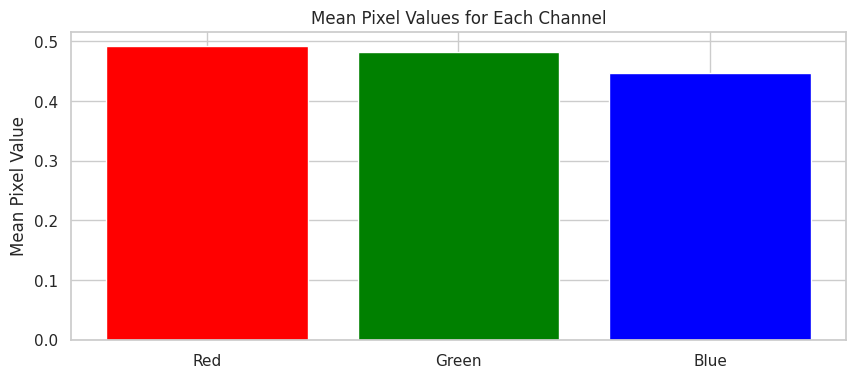

In [ ]:
# Visualizing image mean values
plt.figure(figsize=(10, 4))
plt.bar(['Red', 'Green', 'Blue'], [mean_r, mean_g, mean_b], color=['red', 'green', 'blue'])
plt.title('Mean Pixel Values for Each Channel')
plt.ylabel('Mean Pixel Value')
plt.show()

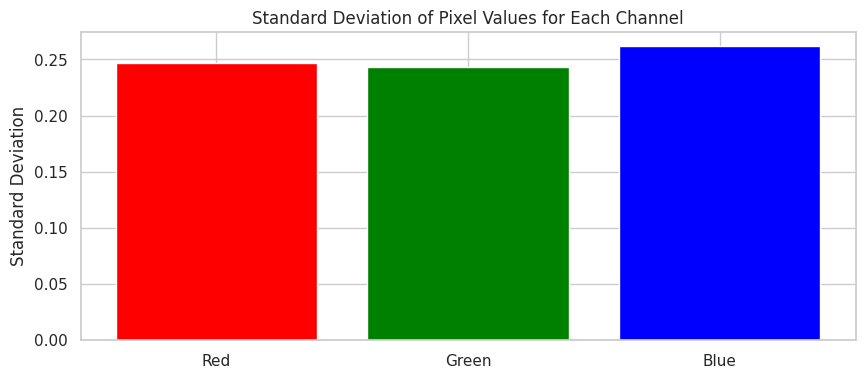

In [ ]:
# Visualizing image standard deviation values
plt.figure(figsize=(10, 4))
plt.bar(['Red', 'Green', 'Blue'], [std_r, std_g, std_b], color=['red', 'green', 'blue'])
plt.title('Standard Deviation of Pixel Values for Each Channel')
plt.ylabel('Standard Deviation')
plt.show()

# 4. Data Augmentation

In [ ]:
# Normalize images to range [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


In [ ]:
# Define data augmentation with ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,   # Set to False since we're normalizing manually
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Re-fit the generator on the training data
datagen.fit(train_images)


In [ ]:
def visualize_augmented_images(datagen, images, num_augmented=5):
    plt.figure(figsize=(15, 3))
    for X_batch, _ in datagen.flow(images, np.zeros(len(images)), batch_size=num_augmented):
        for i in range(num_augmented):
            # Clip the pixel values to be between 0 and 1
            clipped_image = np.clip(X_batch[i], 0, 1)
            plt.subplot(1, num_augmented, i + 1)
            plt.imshow(clipped_image)
            plt.axis('off')
        break
    plt.show()

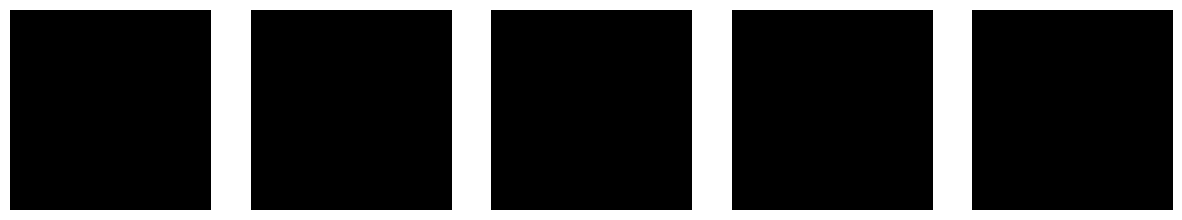

In [ ]:

# Visualize augmented images from the first few images
visualize_augmented_images(datagen, train_images[:10])

In [ ]:
# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

# 5. Building and Tuning Models Using Transfer Learning

In [ ]:
def build_model(hp, base_model):
    # Unfreeze the last 5 layers of the passed base model
    for layer in base_model.layers[-5:]:
        layer.trainable = True

    # Add the base model to the Sequential model
    model = Sequential()
    model.add(base_model)

    # Flatten the output
    model.add(Flatten())

    # Tune a small range for the number of units
    hp_units = hp.Int('units', min_value=64, max_value=128, step=32)
    model.add(Dense(units=hp_units, activation='relu'))

    # Tune a small range for dropout rate
    hp_dropout = hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.1)
    model.add(Dropout(rate=hp_dropout))

    # Output layer
    model.add(Dense(10, activation='softmax'))

    # Choose a small range for learning rates
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

## 5.1 VGG19 Model Tuning

In [ ]:
# Load the VGG19 base model
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers
for layer in vgg19_base.layers:
    layer.trainable = False

# Using Keras Tuner with the modified build_model function
vgg19_tuner = RandomSearch(
    lambda hp: build_model(hp, vgg19_base),  # Pass the base model as a parameter
    objective='val_accuracy',
    max_trials=8,
    executions_per_trial=1,
    directory='quick_tuning',
    project_name='cifar10_vgg16_quick_tuning'
)

In [ ]:
# Start the hyperparameter search with fewer epochs
vgg19_tuner.search(train_images, train_labels,
             epochs=10,  # Limit to a small number of epochs for quick tuning
             validation_data=(test_images, test_labels),
             batch_size=64,  # Adjust if needed
             verbose=2)


Trial 2 Complete [00h 03m 23s]
val_accuracy: 0.10000000149011612

Best val_accuracy So Far: 0.10000000149011612
Total elapsed time: 00h 06m 43s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
128               |96                |units
0.2               |0.2               |dropout_rate
0.001             |0.0001            |learning_rate

Epoch 1/10
782/782 - 24s - 31ms/step - accuracy: 0.0985 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 2/10
782/782 - 35s - 45ms/step - accuracy: 0.0975 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 3/10


In [ ]:
# Retrieve the best hyperparameters
vgg19_best_hyperparameters = vgg19_tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: Units: {vgg19_best_hyperparameters.get('units')}, "
      f"Dropout Rate: {vgg19_best_hyperparameters.get('dropout_rate')}, "
      f"Learning Rate: {vgg19_best_hyperparameters.get('learning_rate')}")

# Retrieve the best model
vgg19_best_model = vgg19_tuner.get_best_models(num_models=1)[0]


In [ ]:
# Recompile the model with the best learning rate (if needed)
vgg19_best_model.compile(optimizer=Adam(learning_rate=vgg19_best_hyperparameters.get('learning_rate')),
                   loss='categorical_crossentropy',
                   metrics=['accuracy', 'Precision', 'Recall'])

In [ ]:
# Continue training the best model for additional epochs
vgg19_history = vgg19_best_model.fit(train_images, train_labels,
                         validation_data=(test_images, test_labels),
                         epochs=10,  # Adjust the number of epochs as needed
                         batch_size=64,  # Can adjust the batch size
                         verbose=1)


## 5.2 ResNet50 Model Tuning

In [ ]:
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 base model
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


In [ ]:
resnet50_tuner = RandomSearch(
    lambda hp: build_model(hp, resnet50_base),  # Pass ResNet50 as the base model
    objective='val_accuracy',
    max_trials=3,  # Limit the number of trials for quick tuning
    executions_per_trial=1,  # Number of times to evaluate each model
    directory='quick_tuning_resnet50',
    project_name='cifar10_resnet50_tuning'
)

In [ ]:
# Start the hyperparameter tuning process
resnet50_tuner.search(train_images, train_labels,
             epochs=3,  # Short tuning process
             validation_data=(test_images, test_labels),
             batch_size=64,
             verbose=2)


In [ ]:
# Retrieve the best hyperparameters
resnet50_best_hyperparameters = resnet50_tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: Units: {resnet50_best_hyperparameters.get('units')}, "
      f"Dropout Rate: {resnet50_best_hyperparameters.get('dropout_rate')}, "
      f"Learning Rate: {resnet50_best_hyperparameters.get('learning_rate')}")

# Retrieve the best model
resnet50_best_model = resnet50_tuner.get_best_models(num_models=1)[0]

In [ ]:
# Recompile the model with the best learning rate (if needed)
resnet50_best_model.compile(optimizer=Adam(learning_rate=resnet50_best_hyperparameters.get('learning_rate')),
                   loss='categorical_crossentropy',
                   metrics=['accuracy', 'Precision', 'Recall'])

In [ ]:
resnet50_history = resnet50_best_model.fit(train_images, train_labels,
                         validation_data=(test_images, test_labels),
                         epochs=10,  # Adjust as needed
                         batch_size=64,
                         verbose=1)

# 6. Model Evaluation and Visualization

In [ ]:
# Function to plot training and validation curves from the model history
def plot_training_history(history, metrics=['accuracy', 'loss', 'Precision', 'Recall']):
    plt.figure(figsize=(12, 7))

    # Loop through each metric and plot the training/validation curves
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)  # Create a grid of subplots

        # Plot training metric
        plt.plot(history.history[metric], label=f'Training {metric.capitalize()}', color='blue')

        # Plot validation metric
        val_metric = f'val_{metric}'
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f'Validation {metric.capitalize()}', color='orange')

        # Set plot details
        plt.title(f'{metric.capitalize()} over Epochs', fontsize=14)
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel(metric.capitalize(), fontsize=12)
        plt.legend()
        plt.grid(True)

    # Adjust the layout for better visualization
    plt.tight_layout()
    plt.show()

In [ ]:
plot_training_history(vgg19_history)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Select 10 random images from the test set
num_images = 10
indices = np.random.choice(test_images.shape[0], num_images, replace=False)
selected_images = test_images[indices]
true_labels = test_labels[indices]

# Make predictions on the selected images
predictions = vgg19_best_model.predict(selected_images)

# Convert predictions and true labels to class indices
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(true_labels, axis=1)

# Visualize the 10 images along with their predicted and actual labels
plt.figure(figsize=(15, 6))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(selected_images[i])
    plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
plot_training_history(resnet50_history)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Select 10 random images from the test set
num_images = 10
indices = np.random.choice(test_images.shape[0], num_images, replace=False)
selected_images = test_images[indices]
true_labels = test_labels[indices]

# Make predictions on the selected images
predictions = resnet50_best_model.predict(selected_images)

# Convert predictions and true labels to class indices
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(true_labels, axis=1)

# Visualize the 10 images along with their predicted and actual labels
plt.figure(figsize=(15, 6))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(selected_images[i])
    plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Function to plot and compare VGG16 and ResNet50 metrics
def compare_vgg_resnet(vgg_history, resnet_history):
    epochs = range(len(vgg_history.history['accuracy']))

    # Plot Training and Validation Accuracy
    plt.figure(figsize=(14, 6))

    # Plot accuracy comparison
    plt.subplot(1, 2, 1)
    plt.plot(epochs, vgg_history.history['accuracy'], label='VGG19 Training Accuracy', color='blue')
    plt.plot(epochs, vgg_history.history['val_accuracy'], label='VGG19 Validation Accuracy', color='blue', linestyle='dashed')

    plt.plot(epochs, resnet_history.history['accuracy'], label='ResNet50 Training Accuracy', color='green')
    plt.plot(epochs, resnet_history.history['val_accuracy'], label='ResNet50 Validation Accuracy', color='green', linestyle='dashed')

    plt.title('VGG19 vs ResNet50 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss comparison
    plt.subplot(1, 2, 2)
    plt.plot(epochs, vgg_history.history['loss'], label='VGG19 Training Loss', color='blue')
    plt.plot(epochs, vgg_history.history['val_loss'], label='VGG19 Validation Loss', color='blue', linestyle='dashed')

    plt.plot(epochs, resnet_history.history['loss'], label='ResNet50 Training Loss', color='green')
    plt.plot(epochs, resnet_history.history['val_loss'], label='ResNet50 Validation Loss', color='green', linestyle='dashed')

    plt.title('VGG19 vs ResNet50 Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:

# Assuming vgg16_history and resnet50_history contain the training histories of VGG16 and ResNet50
compare_vgg_resnet(vgg19_history, resnet50_history)


In [ ]:
# This code trains two image classification models (VGG16 and VGG19) on the CIFAR-10 dataset. Rest Net would be added to help with the models comparision.


